In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from util import log
from modules import *
from dist3 import create_task

In [2]:
#training_set,test_set = create_task()

In [3]:
#training_set['seq_ind'].shape

In [4]:
#training_set['y'].shape

In [5]:
#train = training_set['seq_ind']

In [6]:
#train[0]

In [7]:
from PIL import Image

In [8]:
# Load images
all_imgs = []
n_shapes = 100
for i in range(n_shapes):
	img_fname = '/home/asw3x/emergent_symbols/imgs/' + str(i) + '.png'
	img = torch.Tensor(np.array(Image.open(img_fname))) / 255.
	all_imgs.append(img)
all_imgs = torch.stack(all_imgs, 0)

In [9]:
all_imgs.shape

torch.Size([100, 32, 32])

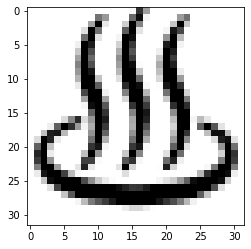

In [10]:
img = all_imgs[0,:,:]
#label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
#print(f"Label: {label}")

In [11]:
#X = all_imgs[train,:,:]

In [12]:
#X.shape

In [13]:
def dist3_ESBN_task():
    training_set,test_set = create_task()
    # Load images
    all_imgs = []
    n_shapes = 100
    for i in range(n_shapes):
        img_fname = '/home/asw3x/emergent_symbols/imgs/' + str(i) + '.png'
        img = torch.Tensor(np.array(Image.open(img_fname))) / 255.
        all_imgs.append(img)
    all_imgs = torch.stack(all_imgs, 0)
    # Create training and test sets
    train = training_set['seq_ind']
    test = test_set['seq_ind']
    X_train = all_imgs[train,:,:]
    X_test = all_imgs[test,:,:]
    Y_train = training_set['y']
    Y_test = test_set['y']
    
    train_set = {'img_seq': X_train, 'y': Y_train}
    test_set = {'img_seq': X_test, 'y': Y_test}
    return train_set, test_set

In [14]:
training_set,test_set = dist3_ESBN_task()

[2021-08-30 16:08:54,771] n_shapes = 100...
[2021-08-30 16:08:54,772] m_holdout = 0...
[2021-08-30 16:08:54,772] Total possible trials = 5821200...
[2021-08-30 16:08:54,773] Training set size = 10000...
[2021-08-30 16:08:54,773] Test set size = 10000...


In [15]:
training_set['img_seq'].shape

torch.Size([10000, 9, 32, 32])

In [16]:
training_set['y'].shape

(10000,)

In [17]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None):
        '''
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        '''
        self.img_seq = dataset['img_seq']
        self.y = dataset['y']

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        '''
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {"image": image, "label": label}
        '''
        img_seq = self.img_seq[idx,:,:,:]
        y = self.y[idx]
        
        return img_seq, y

In [18]:
class Encoder_conv(nn.Module):
	#def __init__(self, args):
	def __init__(self):
		super(Encoder_conv, self).__init__()
		log.info('Building convolutional encoder...')
		# Convolutional layers
		log.info('Conv layers...')
		
		self.conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)
		self.conv2 = nn.Conv2d(32, 32, 4, stride=2, padding=1)
		self.conv3 = nn.Conv2d(32, 32, 4, stride=2, padding=1)
		'''
		self.conv1 = nn.Conv2d(1, 160, 4, stride=2, padding=1)
		self.conv2 = nn.Conv2d(160, 160, 4, stride=2, padding=1)
		self.conv3 = nn.Conv2d(160, 160, 4, stride=2, padding=1)
		'''   
		# Fully-connected layers
		log.info('FC layers...')
		self.fc1 = nn.Linear(4*4*32, 256)
		self.fc2 = nn.Linear(256, 128)
		#self.fc1 = nn.Linear(64000, 256)
		#self.fc2 = nn.Linear(256, 128)
		# Nonlinearities
		self.relu = nn.ReLU()
		# Initialize parameters
		for name, param in self.named_parameters():
			# Initialize all biases to 0
			if 'bias' in name:
				nn.init.constant_(param, 0.0)
			# Initialize all pre-ReLU weights using Kaiming normal distribution
			elif 'weight' in name:
				nn.init.kaiming_normal_(param, nonlinearity='relu')
	def forward(self, x):
		# Convolutional layers
		conv1_out = self.relu(self.conv1(x))
		conv2_out = self.relu(self.conv2(conv1_out))
		conv3_out = self.relu(self.conv3(conv2_out))
		# Flatten output of conv. net
		conv3_out_flat = torch.flatten(conv3_out, 1)
		# Fully-connected layers
		#print("conv3_out_flat.size() =",conv3_out_flat.size())
		#time.sleep(120)
		fc1_out = self.relu(self.fc1(conv3_out_flat))
		fc2_out = self.relu(self.fc2(fc1_out))
		# Output
		z = fc2_out
		return z

In [19]:
class Model(nn.Module):
	#def __init__(self, task_gen, args):
	def __init__(self):
		super(Model, self).__init__()
		# Encoder
		log.info('Building encoder...')
		'''
		if args.encoder == 'conv':
			self.encoder = Encoder_conv(args)
		elif args.encoder == 'mlp':
			self.encoder = Encoder_mlp(args)
		elif args.encoder == 'rand':
			self.encoder = Encoder_rand(args)
		'''
		self.encoder = Encoder_conv()# removed "args" argument
		# LSTM and output layers
		log.info('Building LSTM and output layers...')
		self.z_size = 128
		self.key_size = 256
		self.hidden_size = 512
		self.lstm = nn.LSTM(self.key_size + 1, self.hidden_size, batch_first=True)
		self.key_w_out = nn.Linear(self.hidden_size, self.key_size)
		self.g_out = nn.Linear(self.hidden_size, 1)
		self.confidence_gain = nn.Parameter(torch.ones(1))
		self.confidence_bias = nn.Parameter(torch.zeros(1))
		#self.y_out = nn.Linear(self.hidden_size, task_gen.y_dim)
		y_out = 4 # number of outputs/ ESBN = 4
		self.y_out = nn.Linear(self.hidden_size, y_out)
		# Context normalization
		#if args.norm_type == 'contextnorm' or args.norm_type == 'tasksegmented_contextnorm':
		if True: # assumes "contextnorm or tasksegmented_contextnorm"
			self.contextnorm = True
			self.gamma = nn.Parameter(torch.ones(self.z_size))
			self.beta = nn.Parameter(torch.zeros(self.z_size))
		else:
			self.contextnorm = False
		'''
		if args.norm_type == 'tasksegmented_contextnorm':
			self.task_seg = task_gen.task_seg
		else:
			self.task_seg = [np.arange(task_gen.seq_len)]
		'''
		seq_len = 9 # number of images per Raven problem / ESBN = 9        
		self.task_seg = [np.arange(seq_len)]
		# Nonlinearities
		self.relu = nn.ReLU()
		self.sigmoid = nn.Sigmoid()
		self.softmax = nn.Softmax(dim=1)
		# Initialize parameters
		for name, param in self.named_parameters():
			# Encoder parameters have already been initialized
			if not ('encoder' in name) and not ('confidence' in name):
				# Initialize all biases to 0
				if 'bias' in name:
					nn.init.constant_(param, 0.0)
				else:
					if 'lstm' in name:
						# Initialize gate weights (followed by sigmoid) using Xavier normal distribution
						nn.init.xavier_normal_(param[:self.hidden_size*2,:])
						nn.init.xavier_normal_(param[self.hidden_size*3:,:])
						# Initialize input->hidden and hidden->hidden weights (followed by tanh) using Xavier normal distribution with gain = 
						nn.init.xavier_normal_(param[self.hidden_size*2:self.hidden_size*3,:], gain=5.0/3.0)
					elif 'key_w' in name:
						# Initialize weights for key output layer (followed by ReLU) using Kaiming normal distribution
						nn.init.kaiming_normal_(param, nonlinearity='relu')
					elif 'g_out' in name:
						# Initialize weights for gate output layer (followed by sigmoid) using Xavier normal distribution
						nn.init.xavier_normal_(param)
					elif 'y_out' in name:
						# Initialize weights for multiple-choice output layer (followed by softmax) using Xavier normal distribution
						nn.init.xavier_normal_(param)
	def forward(self, x_seq, device):
		# Encode all images in sequence
		z_seq = []
		for t in range(x_seq.shape[1]):
			x_t = x_seq[:,t,:,:].unsqueeze(1)
			z_t = self.encoder(x_t)
			z_seq.append(z_t)
		z_seq = torch.stack(z_seq, dim=1)
		if self.contextnorm:
			z_seq_all_seg = []
			for seg in range(len(self.task_seg)):
				z_seq_all_seg.append(self.apply_context_norm(z_seq[:,self.task_seg[seg],:]))
			z_seq = torch.cat(z_seq_all_seg, dim=1)
		# Initialize hidden state
		hidden = torch.zeros(1, x_seq.shape[0], self.hidden_size).to(device)
		cell_state = torch.zeros(1, x_seq.shape[0], self.hidden_size).to(device)
		# Initialize retrieved key vector
		key_r = torch.zeros(x_seq.shape[0], 1, self.key_size + 1).to(device)
		# Memory model (extra time step to process key retrieved on final time step)
		for t in range(x_seq.shape[1] + 1):
			# Image embedding
			if t == x_seq.shape[1]:
				z_t = torch.zeros(x_seq.shape[0], 1, self.z_size).to(device)
			else:
				z_t = z_seq[:,t,:].unsqueeze(1)
			# Controller
			# LSTM
			lstm_out, (hidden, cell_state) = self.lstm(key_r, (hidden, cell_state))
			# Key output layers
			key_w = self.relu(self.key_w_out(lstm_out))
			# Gates
			g = self.sigmoid(self.g_out(lstm_out))
			# Task output layer
			y_pred_linear = self.y_out(lstm_out).squeeze()
			y_pred = y_pred_linear.argmax(1)
			# Read from memory
			if t == 0:
				key_r = torch.zeros(x_seq.shape[0], 1, self.key_size + 1).to(device)
			else:
				# Read key
				w_k = self.softmax((z_t * M_v).sum(dim=2))
				c_k = self.sigmoid(((z_t * M_v).sum(dim=2) * self.confidence_gain) + self.confidence_bias)
				key_r = g * (torch.cat([M_k, c_k.unsqueeze(2)], dim=2) * w_k.unsqueeze(2)).sum(1).unsqueeze(1)
			# Write to memory
			if t == 0:
				M_k = key_w
				M_v = z_t
			else:
				M_k = torch.cat([M_k, key_w], dim=1)
				M_v = torch.cat([M_v, z_t], dim=1)
			#print('M_k =',M_k.size())
			#print('M_v =',M_v.size())
		print('y_pred_linear.size()',y_pred_linear.size())
		print('y_pred.size()',y_pred.size())  
		return y_pred_linear, y_pred
	def apply_context_norm(self, z_seq):
		eps = 1e-8
		z_mu = z_seq.mean(1)
		z_sigma = (z_seq.var(1) + eps).sqrt()
		z_seq = (z_seq - z_mu.unsqueeze(1)) / z_sigma.unsqueeze(1)
		z_seq = (z_seq * self.gamma) + self.beta
		return z_seq

In [20]:
training_set = CustomImageDataset(training_set)
train_dataloader = DataLoader(training_set, batch_size=32, shuffle=True)
test_set = CustomImageDataset(test_set)
test_dataloader = DataLoader(test_set, batch_size=32, shuffle=True)

Feature batch shape: torch.Size([32, 9, 32, 32])
Labels batch shape: torch.Size([32])


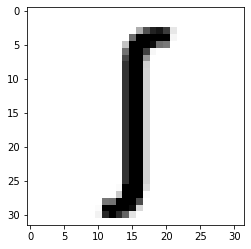

Label: 0


In [21]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0,0,:,:].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([32, 9, 32, 32])
Labels batch shape: torch.Size([32])


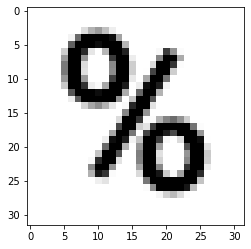

Label: 3


In [22]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0,0,:,:].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [23]:
def train_loop(device, epoch, train_loader, model, optimizer):
	model.train()
	# Iterate over batches
	for batch_idx, (X, y) in enumerate(train_loader):
		# Batch start time
		start_time = time.time()
		# Use sequence indices to slice corresponding images
		#x_seq = all_imgs[seq_ind,:,:]
		x_seq = X.float()
		#print("x_seq.shape =",x_seq.shape)
		# Load data to device
		x_seq = x_seq.to(device)
		#y = torch.nn.functional.one_hot(y,num_classes=4)
		#print("y =",y)
		y = y.to(device)
		# Zero out gradients for optimizer 
		optimizer.zero_grad()
		# Run model 
		'''
		if 'MNM' in args.model_name:
			y_pred_linear, y_pred, const_loss = model(x_seq, device)
		else:
			y_pred_linear, y_pred = model(x_seq, device)
		'''
		y_pred_linear, y_pred = model(x_seq, device)
		# Loss
		loss_fn = nn.CrossEntropyLoss()
		loss = loss_fn(y_pred_linear, y)
		'''
		if 'MNM' in args.model_name:
			loss += const_loss
		'''
		# Update model
		loss.backward()
		optimizer.step()
		# Batch duration
		end_time = time.time()
		batch_dur = end_time - start_time
		# Report prgoress
		#if batch_idx % args.log_interval == 0:
		if batch_idx % 10 == 0:
			# Accuracy
			acc = torch.eq(y_pred, y).float().mean().item() * 100.0
			# Report 	
			log.info('[Epoch: ' + str(epoch) + '] ' + \
					 '[Batch: ' + str(batch_idx) + ' of ' + str(len(train_loader)) + '] ' + \
					 '[Loss = ' + '{:.4f}'.format(loss.item()) + '] ' + \
					 '[Accuracy = ' + '{:.2f}'.format(acc) + '] ' + \
					 '[' + '{:.3f}'.format(batch_dur) + ' sec/batch]')
			# Save progress to file
			'''
			train_prog_f.write(str(batch_idx) + ' ' +\
							   '{:.4f}'.format(loss.item()) + ' ' + \
							   '{:.2f}'.format(acc) + '\n')
			'''

In [24]:
def test_loop(device, epoch, test_loader, model):
	log.info('Evaluating on test set...')
	# Set to eval mode
	model.eval()
	# Iterate over batches
	all_acc = []
	all_loss = []
	for batch_idx, (X, y) in enumerate(test_loader):
		# Use sequence indices to slice corresponding images
		x_seq = X.float()
		# Load data to device
		x_seq = x_seq.to(device)
		#y = torch.nn.functional.one_hot(y,num_classes=4)
		y = y.to(device)
		# Run model 
		'''
		if 'MNM' in args.model_name:
			y_pred_linear, y_pred, const_loss = model(x_seq, device)
		else:
			y_pred_linear, y_pred = model(x_seq, device)
		'''
		y_pred_linear, y_pred = model(x_seq, device)
		# Loss
		loss_fn = nn.CrossEntropyLoss()
		loss = loss_fn(y_pred_linear, y)
		'''
		if 'MNM' in args.model_name:
			loss += const_loss
		'''
		all_loss.append(loss.item())
		# Accuracy
		acc = torch.eq(y_pred, y).float().mean().item() * 100.0
		all_acc.append(acc)
		# Report progress
		log.info('[Batch: ' + str(batch_idx) + ' of ' + str(len(test_loader)) + ']')
	# Report overall test performance
	avg_loss = np.mean(all_loss)
	avg_acc = np.mean(all_acc)
	log.info('[Summary] ' + \
			 '[Loss = ' + '{:.4f}'.format(avg_loss) + '] ' + \
			 '[Accuracy = ' + '{:.2f}'.format(avg_acc) + ']')

In [26]:
learning_rate = 5e-4
batch_size = 32
epochs = 10
device = torch.device("cuda:" + str(1))
model = Model().to(device)
# Initialize the loss function
#loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(device, t+1, train_dataloader, model, optimizer)
test_loop(device,t, test_dataloader, model)
print("Done!")

[2021-08-30 16:11:18,420] Building encoder...
[2021-08-30 16:11:18,421] Building convolutional encoder...
[2021-08-30 16:11:18,421] Conv layers...
[2021-08-30 16:11:18,423] FC layers...
[2021-08-30 16:11:18,426] Building LSTM and output layers...


Epoch 1
-------------------------------


[2021-08-30 16:11:23,317] [Epoch: 1] [Batch: 0 of 313] [Loss = 1.3875] [Accuracy = 25.00] [2.544 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:23,585] [Epoch: 1] [Batch: 10 of 313] [Loss = 1.3811] [Accuracy = 25.00] [0.028 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Siz

[2021-08-30 16:11:23,864] [Epoch: 1] [Batch: 20 of 313] [Loss = 1.3930] [Accuracy = 6.25] [0.031 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:24,146] [Epoch: 1] [Batch: 30 of 313] [Loss = 1.3344] [Accuracy = 56.25] [0.028 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:24,424] [Epoch: 1] [Batch: 40 of 313] [Loss = 1.2017] [Accuracy = 43.75] [0.026 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:24,701] [Epoch: 1] [Batch: 50 of 313] [Loss = 0.8960] [Accuracy = 87.50] [0.029 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Siz

[2021-08-30 16:11:24,981] [Epoch: 1] [Batch: 60 of 313] [Loss = 0.2435] [Accuracy = 87.50] [0.023 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:25,269] [Epoch: 1] [Batch: 70 of 313] [Loss = 0.1609] [Accuracy = 96.88] [0.027 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:25,545] [Epoch: 1] [Batch: 80 of 313] [Loss = 0.0749] [Accuracy = 96.88] [0.027 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:25,824] [Epoch: 1] [Batch: 90 of 313] [Loss = 0.0287] [Accuracy = 100.00] [0.027 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Siz

[2021-08-30 16:11:26,108] [Epoch: 1] [Batch: 100 of 313] [Loss = 0.0145] [Accuracy = 100.00] [0.030 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:26,384] [Epoch: 1] [Batch: 110 of 313] [Loss = 0.0041] [Accuracy = 100.00] [0.027 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:26,664] [Epoch: 1] [Batch: 120 of 313] [Loss = 0.0014] [Accuracy = 100.00] [0.031 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:26,948] [Epoch: 1] [Batch: 130 of 313] [Loss = 0.0136] [Accuracy = 100.00] [0.028 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Siz

[2021-08-30 16:11:27,213] [Epoch: 1] [Batch: 140 of 313] [Loss = 0.0294] [Accuracy = 100.00] [0.023 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:27,500] [Epoch: 1] [Batch: 150 of 313] [Loss = 0.2982] [Accuracy = 96.88] [0.028 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:27,775] [Epoch: 1] [Batch: 160 of 313] [Loss = 0.0047] [Accuracy = 100.00] [0.022 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Siz

[2021-08-30 16:11:28,054] [Epoch: 1] [Batch: 170 of 313] [Loss = 0.2769] [Accuracy = 96.88] [0.024 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:28,333] [Epoch: 1] [Batch: 180 of 313] [Loss = 0.1891] [Accuracy = 96.88] [0.023 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:28,612] [Epoch: 1] [Batch: 190 of 313] [Loss = 0.0072] [Accuracy = 100.00] [0.023 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:28,901] [Epoch: 1] [Batch: 200 of 313] [Loss = 0.0037] [Accuracy = 100.00] [0.028 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Siz

[2021-08-30 16:11:29,168] [Epoch: 1] [Batch: 210 of 313] [Loss = 0.0039] [Accuracy = 100.00] [0.023 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:29,449] [Epoch: 1] [Batch: 220 of 313] [Loss = 0.0007] [Accuracy = 100.00] [0.028 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:29,732] [Epoch: 1] [Batch: 230 of 313] [Loss = 0.0018] [Accuracy = 100.00] [0.027 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:30,021] [Epoch: 1] [Batch: 240 of 313] [Loss = 0.0017] [Accuracy = 100.00] [0.029 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Siz

[2021-08-30 16:11:30,308] [Epoch: 1] [Batch: 250 of 313] [Loss = 0.0021] [Accuracy = 100.00] [0.027 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:30,601] [Epoch: 1] [Batch: 260 of 313] [Loss = 0.0059] [Accuracy = 100.00] [0.028 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Siz

[2021-08-30 16:11:30,886] [Epoch: 1] [Batch: 270 of 313] [Loss = 0.0058] [Accuracy = 100.00] [0.026 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:31,166] [Epoch: 1] [Batch: 280 of 313] [Loss = 0.0019] [Accuracy = 100.00] [0.025 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:31,456] [Epoch: 1] [Batch: 290 of 313] [Loss = 0.1347] [Accuracy = 96.88] [0.027 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:31,741] [Epoch: 1] [Batch: 300 of 313] [Loss = 0.0882] [Accuracy = 96.88] [0.028 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Siz

[2021-08-30 16:11:32,016] [Epoch: 1] [Batch: 310 of 313] [Loss = 0.0533] [Accuracy = 96.88] [0.023 sec/batch]
[2021-08-30 16:11:32,109] [Epoch: 2] [Batch: 0 of 313] [Loss = 0.0044] [Accuracy = 100.00] [0.029 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([16, 4])
y_pred.size() torch.Size([16])
Epoch 2
-------------------------------
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:32,393] [Epoch: 2] [Batch: 10 of 313] [Loss = 0.0426] [Accuracy = 100.00] [0.029 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Siz

[2021-08-30 16:11:32,672] [Epoch: 2] [Batch: 20 of 313] [Loss = 0.0812] [Accuracy = 96.88] [0.030 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:32,955] [Epoch: 2] [Batch: 30 of 313] [Loss = 0.0249] [Accuracy = 100.00] [0.027 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:33,211] [Epoch: 2] [Batch: 40 of 313] [Loss = 0.0063] [Accuracy = 100.00] [0.027 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:33,481] [Epoch: 2] [Batch: 50 of 313] [Loss = 0.1855] [Accuracy = 96.88] [0.028 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Siz

[2021-08-30 16:11:33,757] [Epoch: 2] [Batch: 60 of 313] [Loss = 0.0372] [Accuracy = 100.00] [0.029 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:34,016] [Epoch: 2] [Batch: 70 of 313] [Loss = 0.0387] [Accuracy = 100.00] [0.026 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:34,286] [Epoch: 2] [Batch: 80 of 313] [Loss = 0.0100] [Accuracy = 100.00] [0.025 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:34,560] [Epoch: 2] [Batch: 90 of 313] [Loss = 0.0127] [Accuracy = 100.00] [0.027 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Siz

[2021-08-30 16:11:34,830] [Epoch: 2] [Batch: 100 of 313] [Loss = 0.0066] [Accuracy = 100.00] [0.025 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:35,104] [Epoch: 2] [Batch: 110 of 313] [Loss = 0.0051] [Accuracy = 100.00] [0.028 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:35,373] [Epoch: 2] [Batch: 120 of 313] [Loss = 0.0271] [Accuracy = 100.00] [0.029 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:35,647] [Epoch: 2] [Batch: 130 of 313] [Loss = 0.0013] [Accuracy = 100.00] [0.026 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Siz

[2021-08-30 16:11:35,921] [Epoch: 2] [Batch: 140 of 313] [Loss = 0.0071] [Accuracy = 100.00] [0.026 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:36,200] [Epoch: 2] [Batch: 150 of 313] [Loss = 0.0077] [Accuracy = 100.00] [0.028 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:36,470] [Epoch: 2] [Batch: 160 of 313] [Loss = 0.0026] [Accuracy = 100.00] [0.026 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:36,758] [Epoch: 2] [Batch: 170 of 313] [Loss = 0.0011] [Accuracy = 100.00] [0.028 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Siz

[2021-08-30 16:11:37,033] [Epoch: 2] [Batch: 180 of 313] [Loss = 0.0036] [Accuracy = 100.00] [0.028 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:37,308] [Epoch: 2] [Batch: 190 of 313] [Loss = 0.0028] [Accuracy = 100.00] [0.028 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:37,582] [Epoch: 2] [Batch: 200 of 313] [Loss = 0.0026] [Accuracy = 100.00] [0.025 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Siz

[2021-08-30 16:11:37,862] [Epoch: 2] [Batch: 210 of 313] [Loss = 0.0008] [Accuracy = 100.00] [0.025 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:38,139] [Epoch: 2] [Batch: 220 of 313] [Loss = 0.0008] [Accuracy = 100.00] [0.026 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:38,417] [Epoch: 2] [Batch: 230 of 313] [Loss = 0.0015] [Accuracy = 100.00] [0.028 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:38,682] [Epoch: 2] [Batch: 240 of 313] [Loss = 0.0024] [Accuracy = 100.00] [0.026 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Siz

[2021-08-30 16:11:38,956] [Epoch: 2] [Batch: 250 of 313] [Loss = 0.0031] [Accuracy = 100.00] [0.029 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:39,236] [Epoch: 2] [Batch: 260 of 313] [Loss = 0.0028] [Accuracy = 100.00] [0.028 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:39,513] [Epoch: 2] [Batch: 270 of 313] [Loss = 0.0024] [Accuracy = 100.00] [0.029 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:39,784] [Epoch: 2] [Batch: 280 of 313] [Loss = 0.0020] [Accuracy = 100.00] [0.030 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Siz

[2021-08-30 16:11:40,064] [Epoch: 2] [Batch: 290 of 313] [Loss = 0.0043] [Accuracy = 100.00] [0.027 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:40,344] [Epoch: 2] [Batch: 300 of 313] [Loss = 0.0009] [Accuracy = 100.00] [0.029 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:40,625] [Epoch: 2] [Batch: 310 of 313] [Loss = 0.0127] [Accuracy = 100.00] [0.029 sec/batch]
[2021-08-30 16:11:40,705] [Epoch: 3] [Batch: 0 of 313] [Loss = 0.0009] [Accuracy = 100.00] [0.028 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([16, 4])
y_pred.size() torch.Size([16])
Epoch 3
-------------------------------
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() tor

[2021-08-30 16:11:40,977] [Epoch: 3] [Batch: 10 of 313] [Loss = 0.0010] [Accuracy = 100.00] [0.029 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:41,247] [Epoch: 3] [Batch: 20 of 313] [Loss = 0.0009] [Accuracy = 100.00] [0.032 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:41,535] [Epoch: 3] [Batch: 30 of 313] [Loss = 0.0013] [Accuracy = 100.00] [0.029 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Siz

[2021-08-30 16:11:41,809] [Epoch: 3] [Batch: 40 of 313] [Loss = 0.0012] [Accuracy = 100.00] [0.024 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:42,095] [Epoch: 3] [Batch: 50 of 313] [Loss = 0.0040] [Accuracy = 100.00] [0.028 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:42,365] [Epoch: 3] [Batch: 60 of 313] [Loss = 0.0028] [Accuracy = 100.00] [0.026 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


[2021-08-30 16:11:42,648] [Epoch: 3] [Batch: 70 of 313] [Loss = 0.2093] [Accuracy = 93.75] [0.026 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Siz

[2021-08-30 16:11:42,929] [Epoch: 3] [Batch: 80 of 313] [Loss = 0.0097] [Accuracy = 100.00] [0.028 sec/batch]


y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])
y_pred_linear.size() torch.Size([32, 4])
y_pred.size() torch.Size([32])


KeyboardInterrupt: 